In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import scipy

from data_preprocessing.data_preprocessing import get_experimental_data

from inference.loss import LossTeaching
from inference.train import train

from plot.plot_hist_loss import plot_loss
from plot.plot_posterior import plot_posterior

In [2]:
%config InlineBackend.figure_format = 'retina'
sns.set()

We assume the following model:

\begin{align}
Z_u^\rho &\sim \mathcal{N}(0, \sigma_u^\rho)\\
Z_w^\rho &\sim \mathcal{N}(0, \sigma_w^\rho) \\
Z_{u, w}^\rho &= \mu^\rho + Z_u^\rho + Z_w^\rho \\
\end{align}
where $Z_u^{\rho}$ is a random variable whose distribution is specific to user $u$ and parameter $\rho$, and $\rho \in {\alpha, \beta}$.

The probability of recall for user $u$ and item/word $w$ at time $t$ is defined as:
\begin{align}
p(\omega = 1 \mid t, u, w) &= e^{-Z_{u, w}^\alpha (1-Z_{u, w}^\beta)^n \delta_{u, w}^t}  \\
\end{align}
where $\delta_{u, w}^t$ is the time elapsed since the last presentation for user $u$, item $w$ at time $t$.


# Run on experimental data

In [3]:
data = get_experimental_data()

Number of user 53
Number of items 1998
Total number of observations (excluding first presentation) 70618
Minimum number of observation for a single user 1285
Maximum number of observation for a single user 1404


In [6]:
z_flow, theta_flow, hist_loss = train(
    data,
    n_sample=40,
    epochs=5000)

100%|██████████████████████████| 5000/5000 [09:18<00:00,  8.96it/s, loss=4.3e+4]


In [19]:
run_name = "jupyter_exp_data"

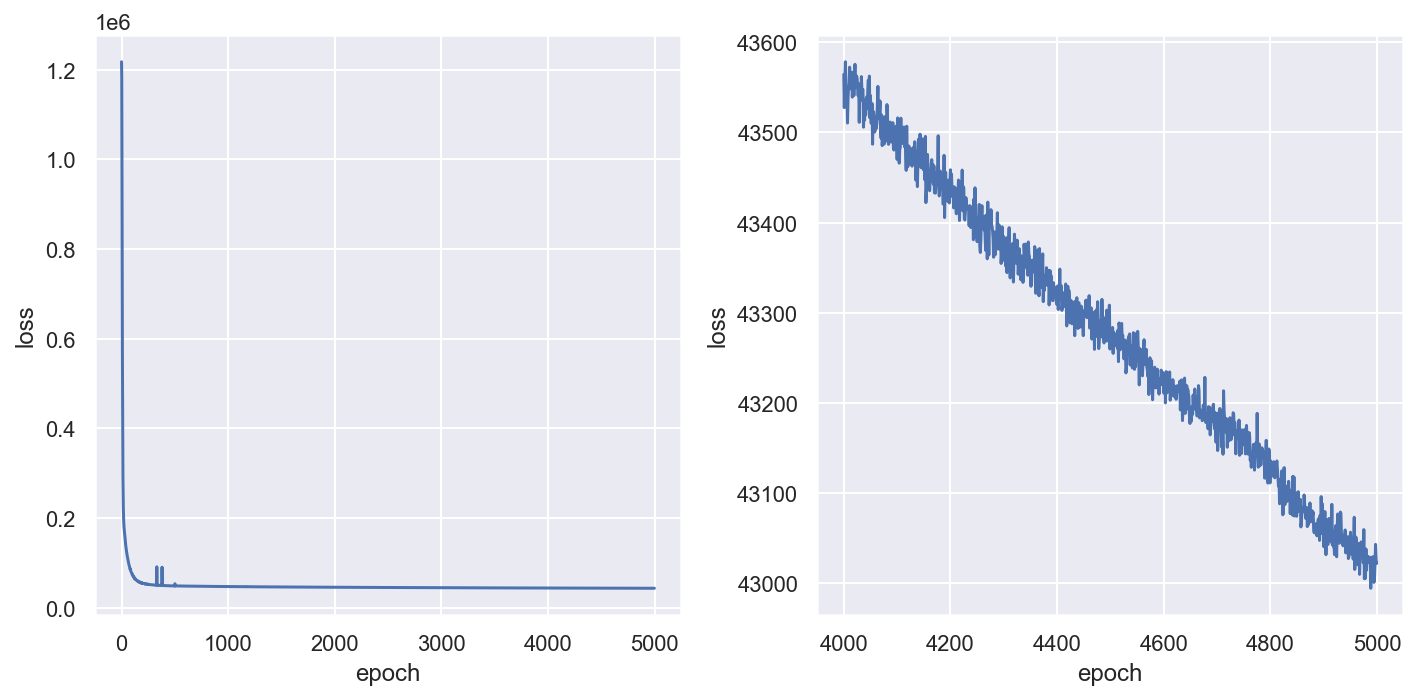

In [10]:
plot_loss(path=f"fig/{run_name}/loss.pdf", hist_loss=hist_loss)

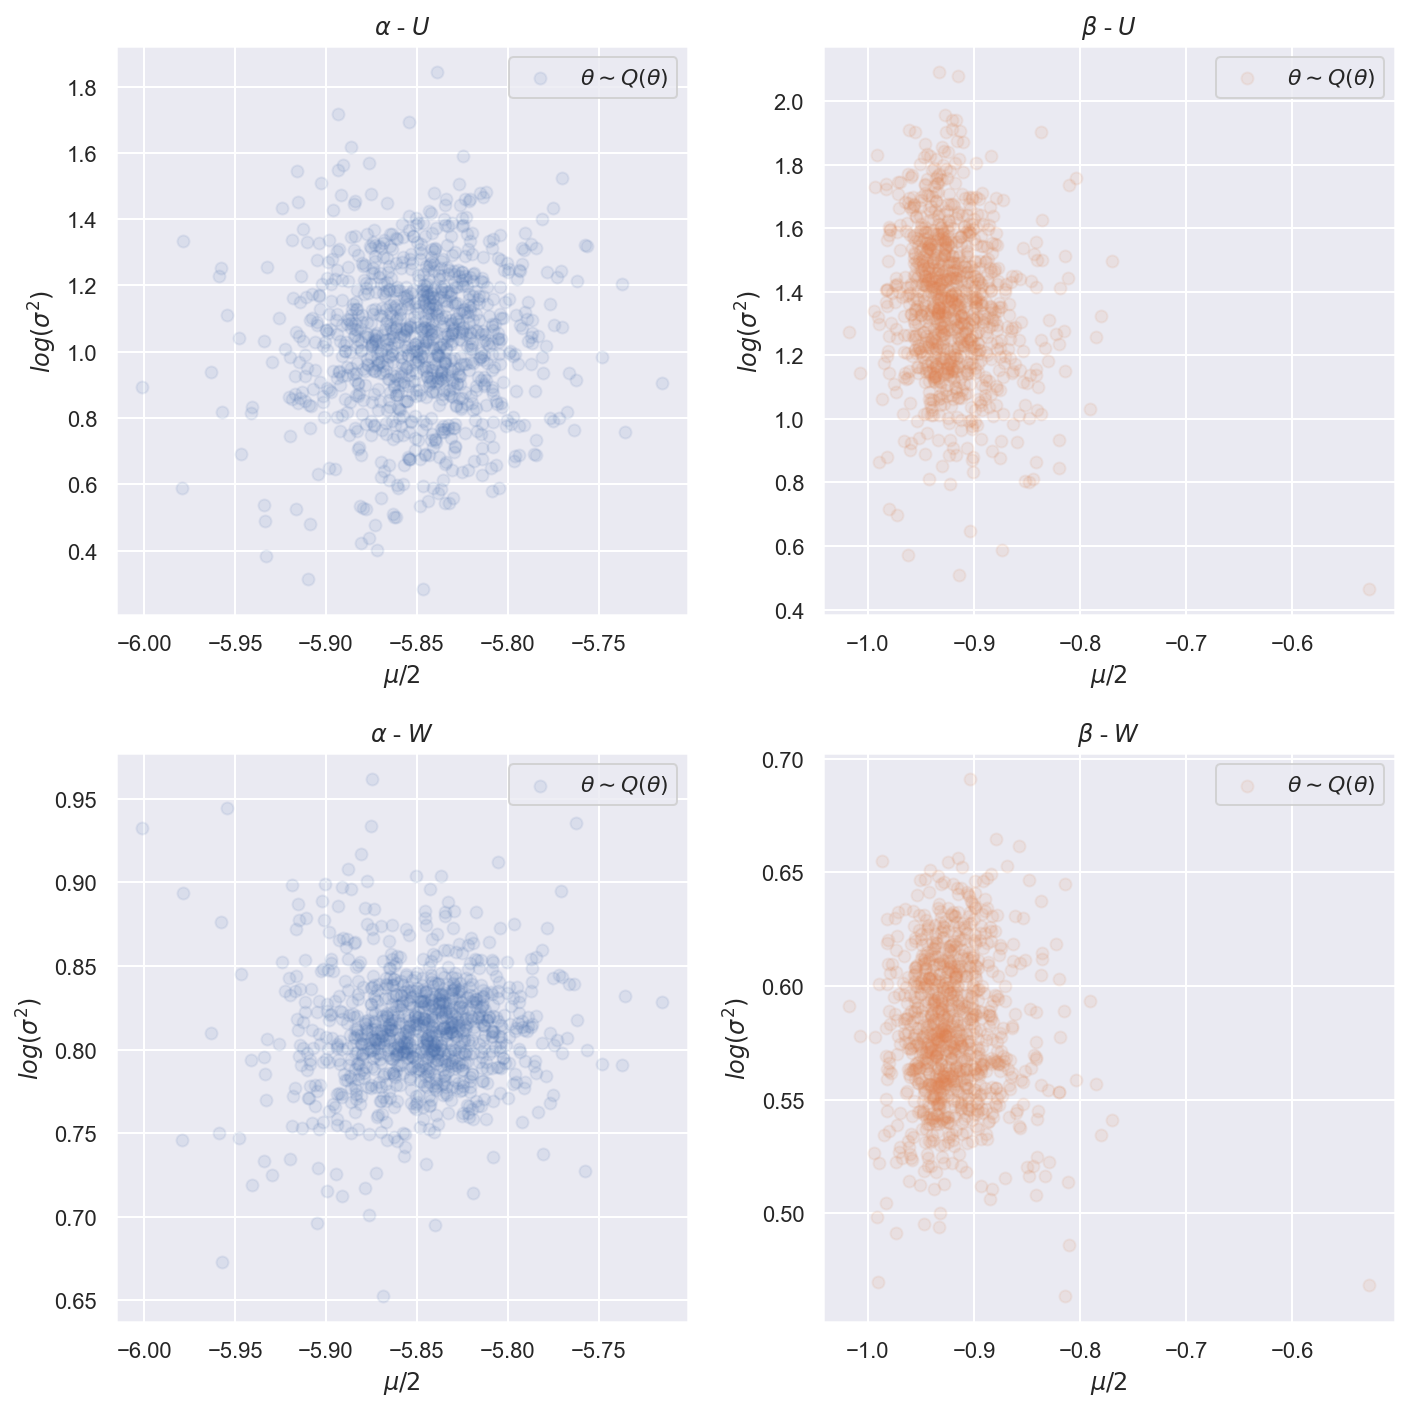

In [11]:
plot_posterior(path=f"fig/{run_name}/posterior.pdf", theta_flow=theta_flow)

In [13]:
z_flow.save(f"bkp/{run_name}/z_flow.p")
theta_flow.save(f"bkp/{run_name}/theta_flow.p")

In [14]:
batch_size = 100000

z0_θ = theta_flow.sample_base_dist(batch_size)
zk_θ, base_dist_logprob_θ, log_det_θ = theta_flow(z0_θ)

mu1, log_var_u1, log_var_w1 = zk_θ.data[:, :3].T
mu2, log_var_u2, log_var_w2 = zk_θ.data[:, 3:].T

In [15]:
unconstrained = {
    "mu1": mu1.mean().item(), 
    "sigma_u1": np.exp(0.5*log_var_u1.mean().item()), 
    "sigma_w1": np.exp(0.5*log_var_w1.mean().item()),
    "mu2": mu2.mean().item(), 
    "sigma_u2": np.exp(0.5*log_var_u2.mean().item()),
    "sigma_w2": np.exp(0.5*log_var_w2.mean().item())}

df_param = pd.DataFrame([unconstrained, ], index=["unconstrained",])
df_param

,mu1,sigma_u1,sigma_w1,mu2,sigma_u2,sigma_w2
unconstrained,-5.849018,1.679971,1.500086,-0.920574,1.975944,1.337099


In [16]:
df_param.to_csv(os.path.join("bkp", "param_exp_data.csv"))

In [17]:
unc_a = np.random.normal(df_param.loc["unconstrained", "mu1"], df_param.loc["unconstrained", "sigma_u1"], size=1000)

In [18]:
unc_a

array([ -7.67284534,  -4.17350638,  -5.373622  ,  -8.37954877,
        -6.82104915,  -3.07465245,  -9.92576791,  -6.56957832,
        -3.72228166,  -7.30511619,  -6.98952654,  -6.00812592,
        -3.34352659,  -6.92235432,  -6.59489435,  -6.57871508,
        -2.14311948,  -2.17528083,  -4.16223638,  -5.20023574,
        -4.61025994,  -3.34463133,  -7.4211912 ,  -3.87365915,
        -7.95550054,  -6.92042153,  -4.32510737,  -8.24915949,
        -6.08432898,  -7.29674069,  -6.2784507 , -10.55056562,
        -8.82514152,  -7.02479094,  -4.29090781,  -6.1407205 ,
        -5.84423656,  -4.69282356,  -7.326613  ,  -5.372532  ,
        -7.20200986,  -8.75145194,  -6.50571786,  -4.88504052,
        -5.2801979 ,  -5.86889251,  -1.82991381,  -5.15533724,
        -4.2047697 ,  -2.08900215,  -8.02304319,  -7.59415149,
        -2.91963199,  -7.18973972,  -5.79915066,  -4.05259801,
        -4.35265688,  -2.90086006,  -3.33637913,  -4.05246915,
        -7.1471457 ,  -4.51367154,  -5.32104984,  -8.07